In [29]:
import pandas as pd
from time import time

In [30]:
print("Let's start")

#Data preprocessing
dataroot="../MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
df=pd.read_csv(dataroot,header=0,low_memory=False)
pd.set_option('mode.use_inf_as_na', True) # convert inf to nan
df['Flow Bytes/s']=df['Flow Bytes/s'].astype('float64')
df[' Flow Packets/s']=df[' Flow Packets/s'].astype('float64')
df['Flow Bytes/s'].fillna(df['Flow Bytes/s'].mean(),inplace=True)
df[' Flow Packets/s'].fillna(df[' Flow Packets/s'].mean(),inplace=True)
df[' Label'] = df[' Label'].apply(lambda x: 0 if 'BENIGN' in x else 1)

#train_test_split
from sklearn.model_selection import train_test_split
t0 = time()
X_train, X_test, y_train,y_test = train_test_split(df.iloc[:,0:-1], df[' Label'], test_size=0.3, random_state=42)
tt = time()-t0
print ("Split dataset in {} seconds".format(round(tt,3)))

Let's start
Split dataset in 0.57 seconds


In [31]:
#Feature scaling
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)
    


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [37]:
print(X_train.shape)
print(X_test.shape)
print(X_train)
print(y_train.values)

(158021, 78)
(67724, 78)
[[1.22077764e-03 3.51283705e-04 1.03573278e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.22077764e-03 7.37936864e-01 3.62506473e-03 ... 7.96324655e-01
  6.71666667e-01 5.90077917e-02]
 [1.22077764e-03 6.60858199e-03 1.03573278e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.22077764e-03 5.99121467e-03 1.03573278e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.84804370e-01 2.46561928e-03 2.58933195e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.22077764e-03 4.99657529e-02 2.07146556e-03 ... 0.00000000e+00
  4.99404667e-02 4.99404667e-02]]
[1 1 1 ... 1 0 1]


In [34]:
print(X_train[:,0])
print(X_train[0:10,1])

[0.00122078 0.00122078 0.00122078 ... 0.00122078 0.88480437 0.00122078]
[3.51283705e-04 7.37936864e-01 6.60858199e-03 6.82623531e-01
 1.82650193e-03 7.73492485e-04 3.57241128e-02 4.21315446e-03
 1.91666870e-06 4.07067097e-04]


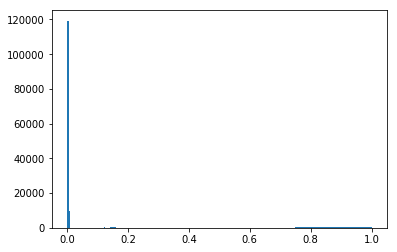

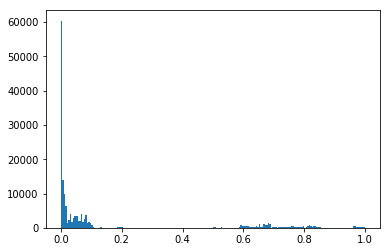

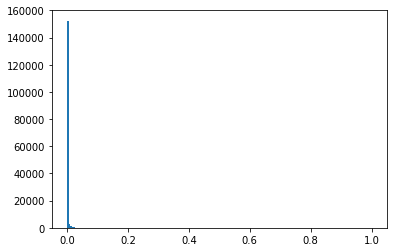

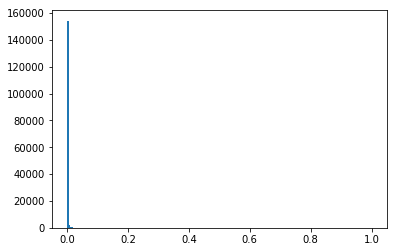

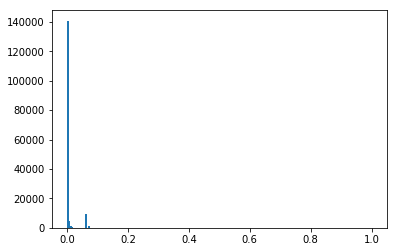

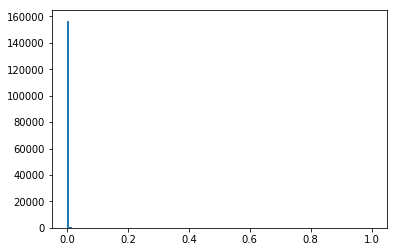

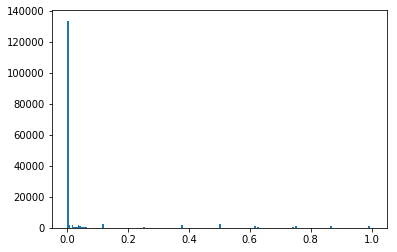

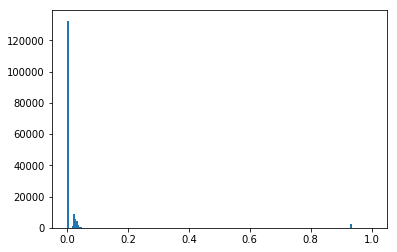

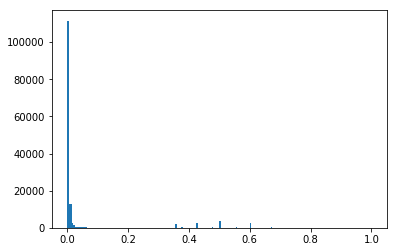

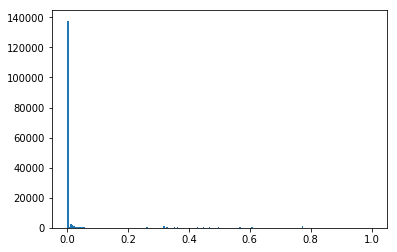

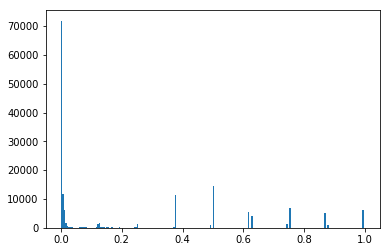

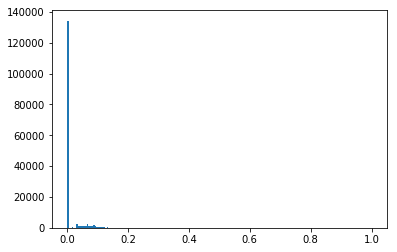

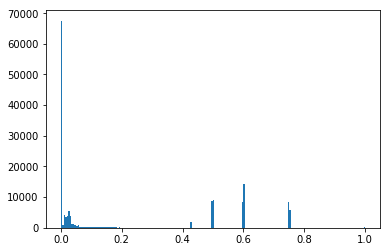

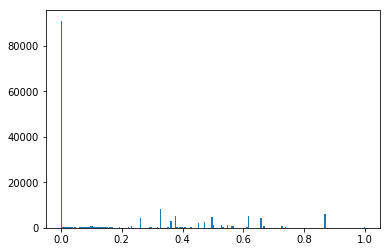

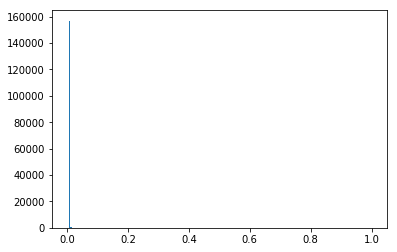

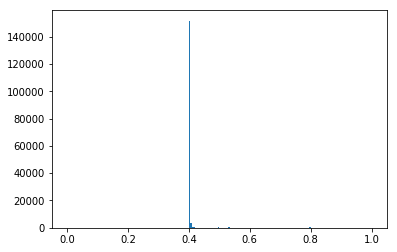

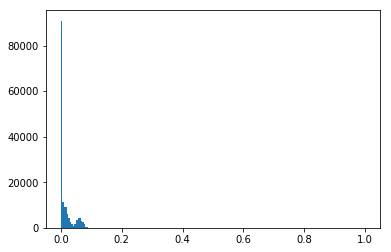

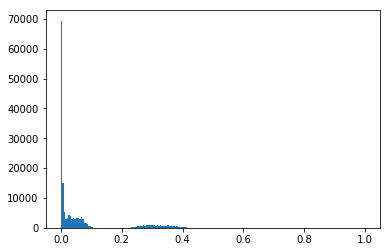

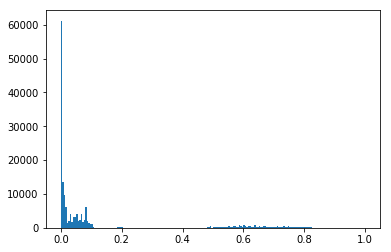

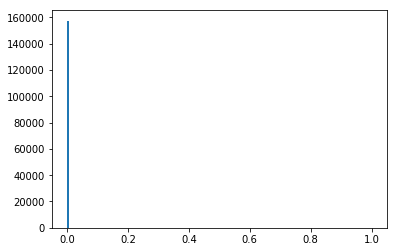

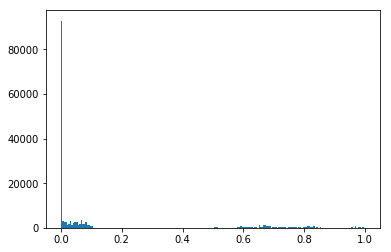

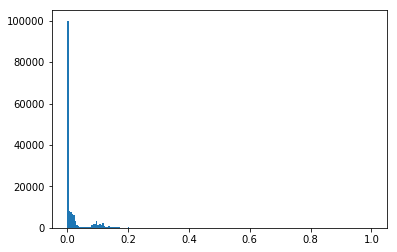

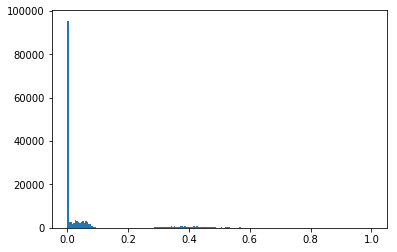

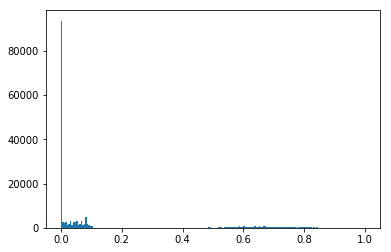

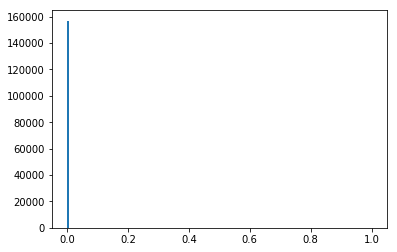

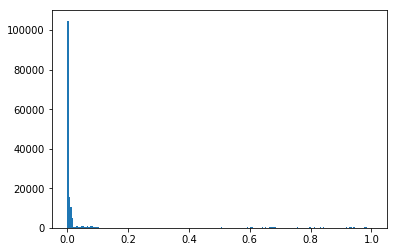

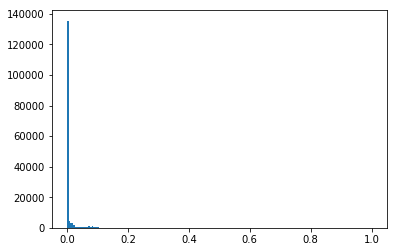

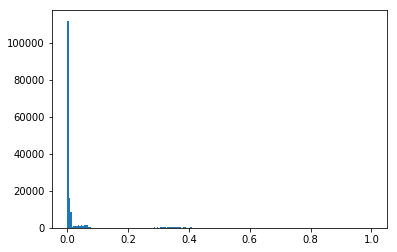

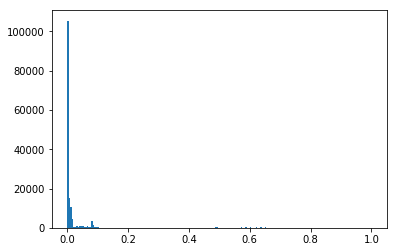

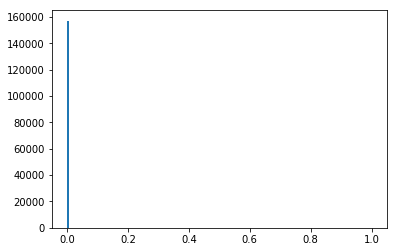

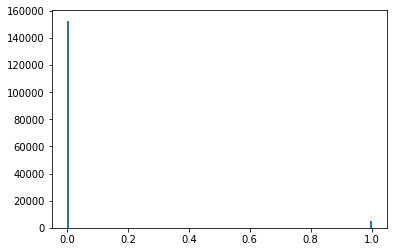

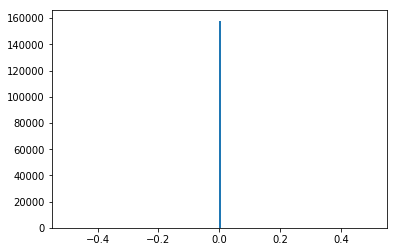

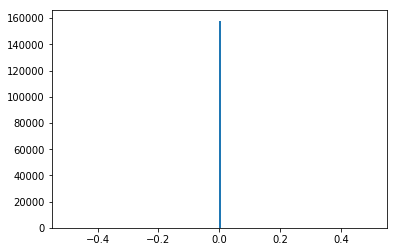

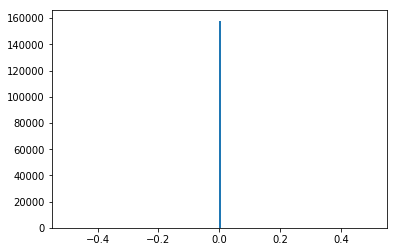

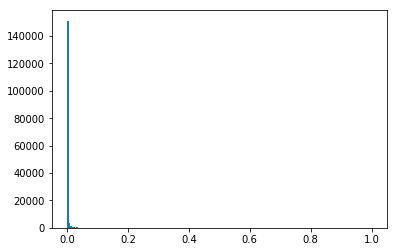

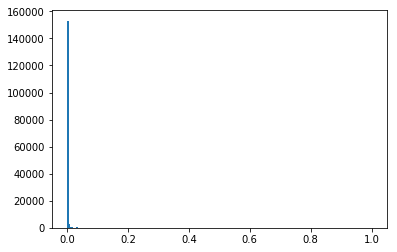

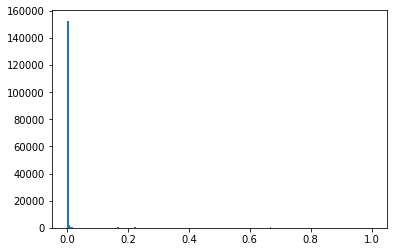

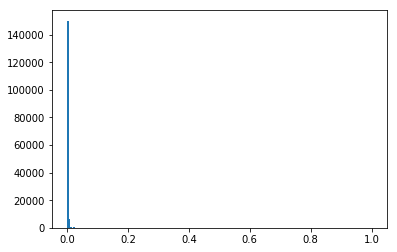

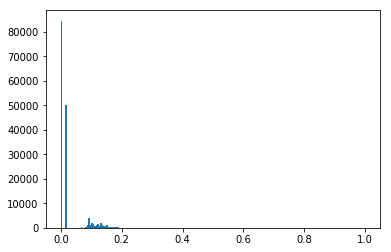

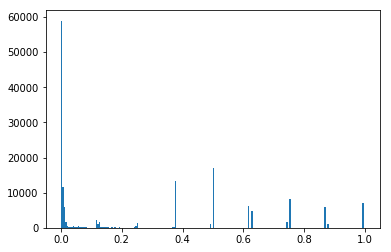

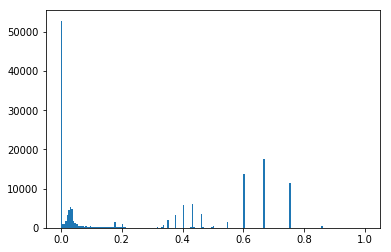

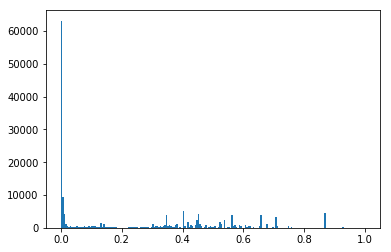

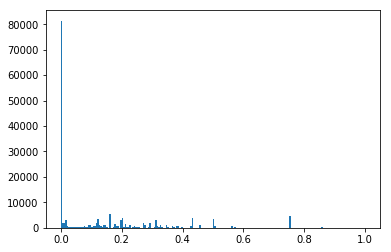

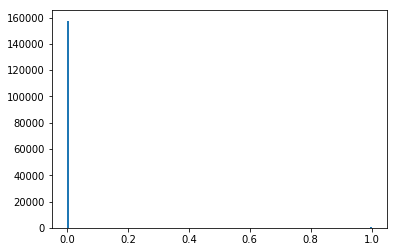

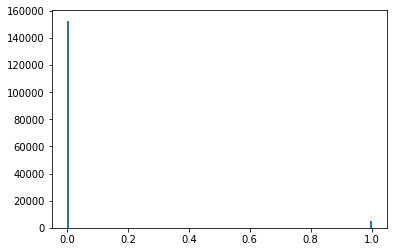

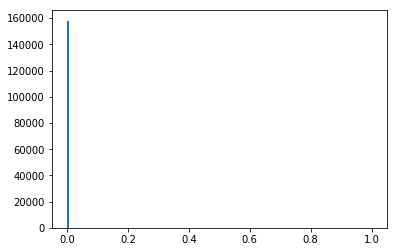

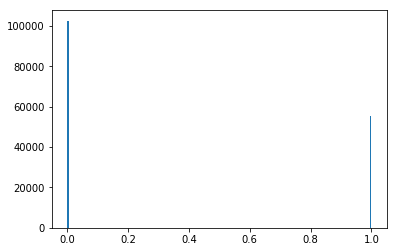

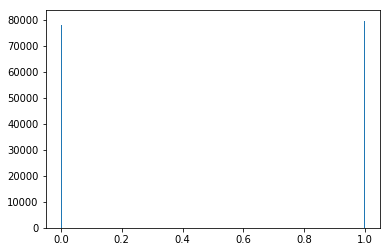

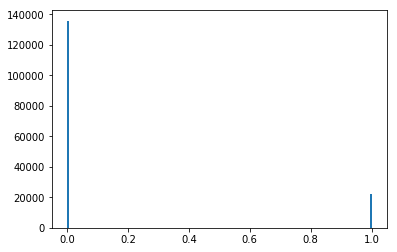

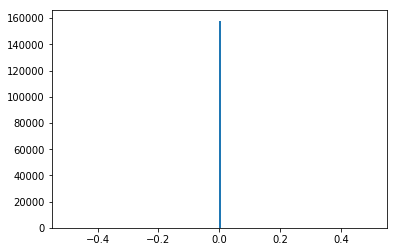

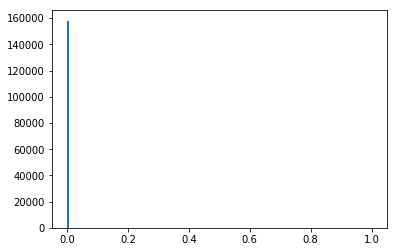

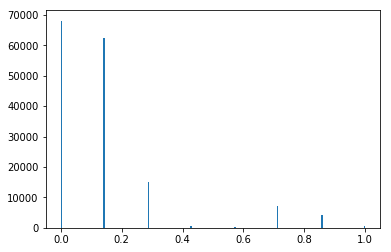

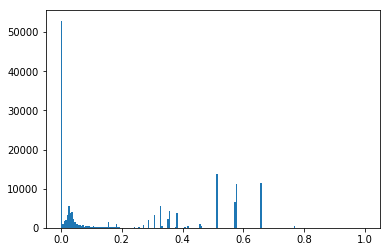

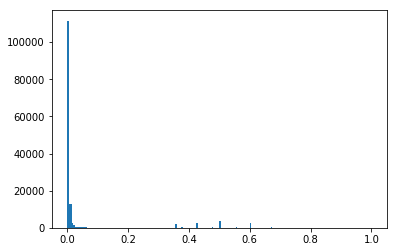

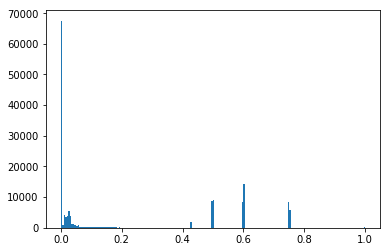

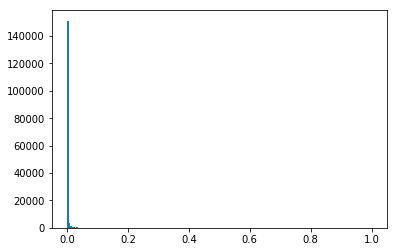

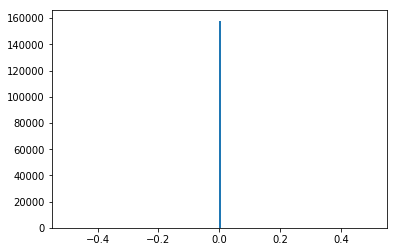

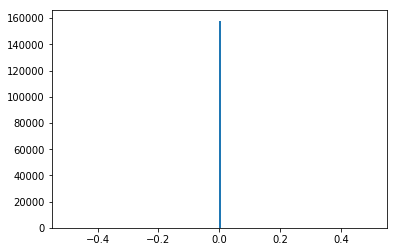

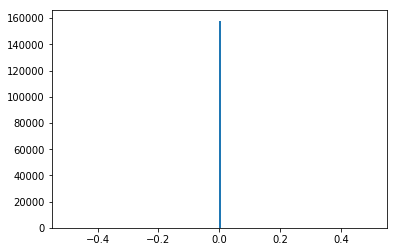

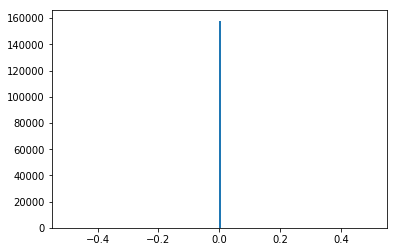

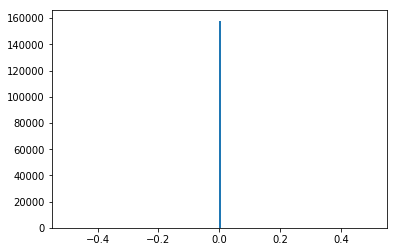

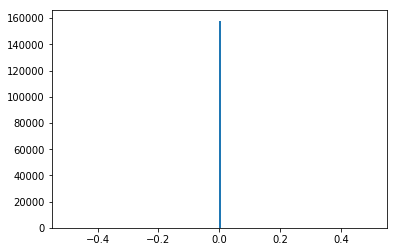

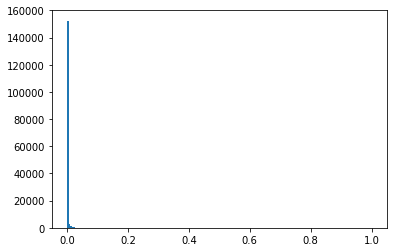

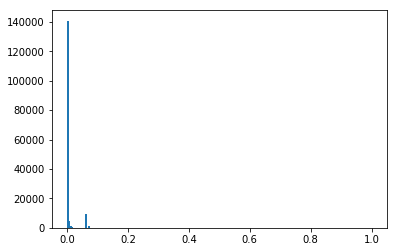

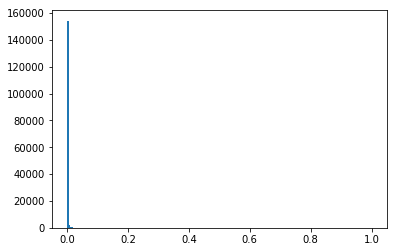

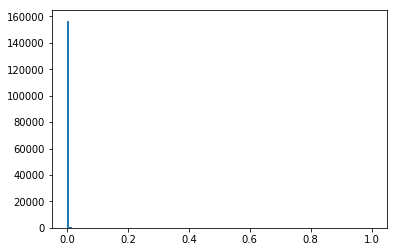

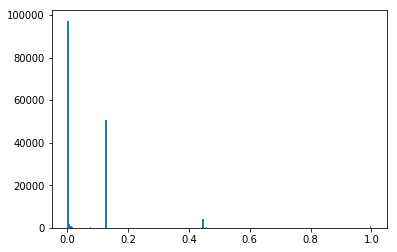

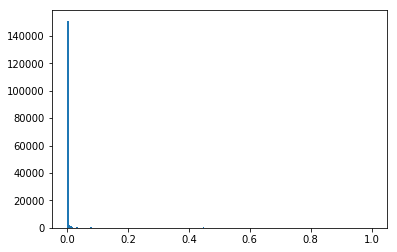

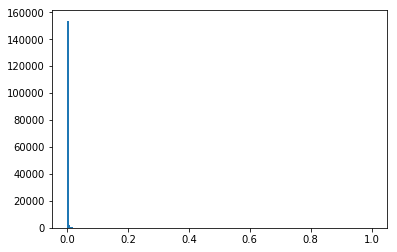

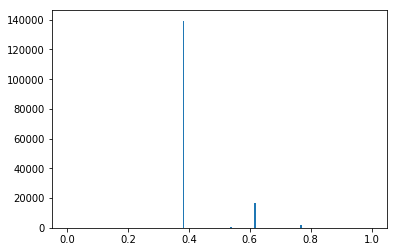

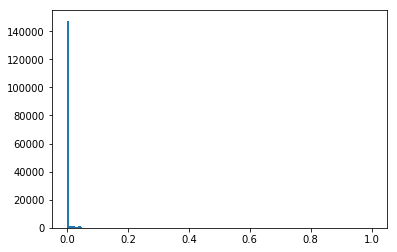

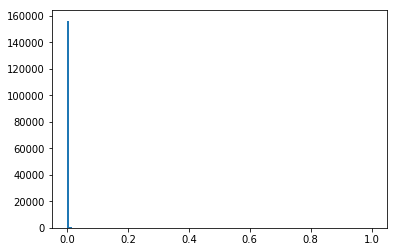

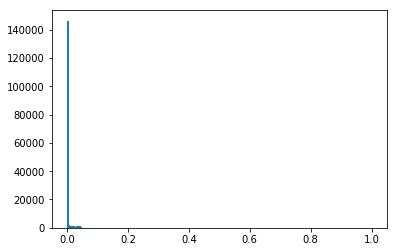

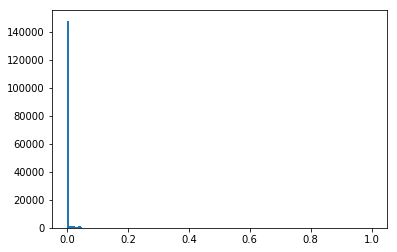

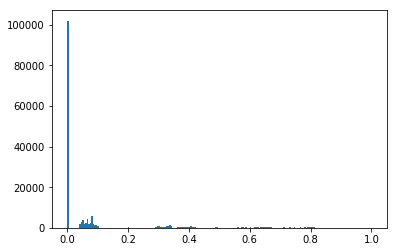

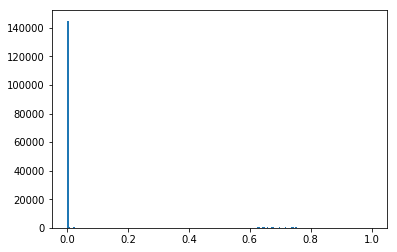

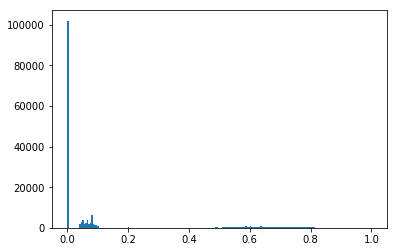

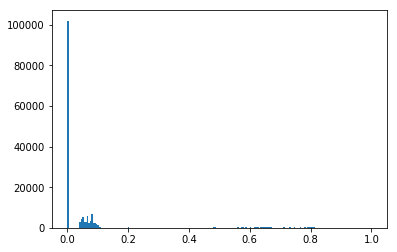

In [35]:
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
array = []

for i in range(78):
    plt.hist(X_train[:,i],200)
    plt.show()
    


In [45]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
#超参数设置
learning_rate = 0.001
epochs = 10
batch_size = 256
activation = tf.nn.relu         #非输出层下的激活函数


In [46]:
#用于记录训练中每个batch的loss
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.train_losses_per_batch = []
        self.train_losses_per_epoch = []
        self.valid_losses_per_epoch = []
        
    def on_batch_end(self, batch, logs={}):
        self.train_losses_per_batch.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs={}):
        self.train_losses_per_epoch.append(logs.get('loss'))
        self.valid_losses_per_epoch.append(logs.get('val_loss')*9)   #验证集由于只有1/9的训练集大小所以损失要乘以9
#用于记录训练中每个epoch的召回率，精确度以及f1 score
class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        return

    def on_epoch_end(self, epoch, logs={}):
        predictions = self.model.predict(X_test)
        val_predict = np.argmax(predictions, axis=1)     #把独热编码转化成数字
        val_targ = y_test
        _val_recall = recall_score(val_targ, val_predict, average='macro')
        _val_precision = precision_score(val_targ, val_predict, average='macro')
        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        return       

def simple_model():
    model = keras.Sequential([
        keras.layers.Dense(X_train.shape[1], activation=activation, input_shape=(X_train.shape[1],)),
        keras.layers.Dense(X_train.shape[1], activation=activation),
        keras.layers.Dense(11,activation=tf.nn.softmax)
    ])
    model.compile(optimizer =tf.train.AdamOptimizer(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=['accuracy']
    )
    model.summary()
    history = LossHistory()
    metrics = Metrics()
    model.fit(
        X_train,y_train.values,
        validation_data=[X_test, y_test.values],
        batch_size=batch_size,epochs=epochs,
        callbacks=[history, metrics]
    )   
    return model,history,metrics
model,history,metrics = simple_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 78)                6162      
_________________________________________________________________
dense_4 (Dense)              (None, 78)                6162      
_________________________________________________________________
dense_5 (Dense)              (None, 11)                869       
Total params: 13,193
Trainable params: 13,193
Non-trainable params: 0
_________________________________________________________________
Train on 158021 samples, validate on 67724 samples
Epoch 1/10
158021/158021 [==============================] - 9s 54us/sample - loss: 0.1387 - acc: 0.9724 - val_loss: 0.0371 - val_acc: 0.9858
Epoch 2/10
158021/158021 [==============================] - 9s 54us/sample - loss: 0.0191 - acc: 0.9923 - val_loss: 0.0326 - val_acc: 0.9893
Epoch 3/10
158021/158021 [==============================] - 8s 51us/s

/opt/conda/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


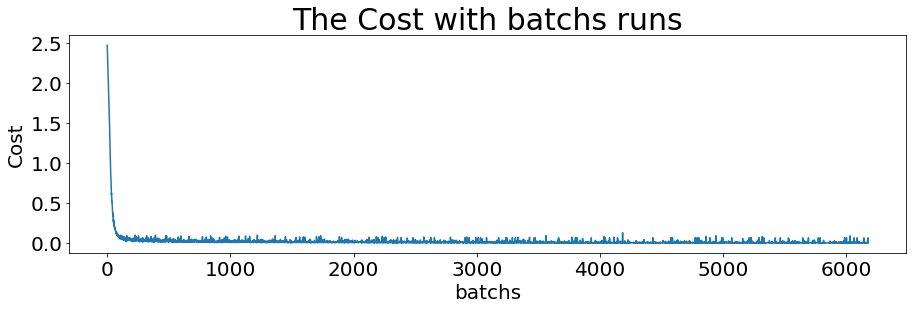

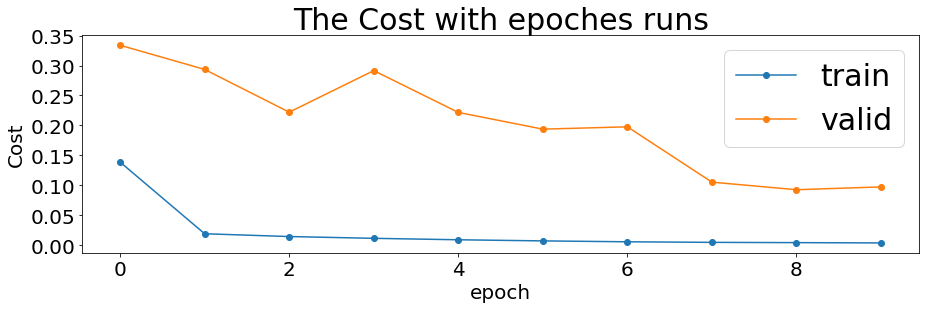

In [47]:
#绘制训练集在batch下的损失变化
plt.title('The Cost with batchs runs',fontsize=30)
plt.xlabel('batchs',fontsize=20)
plt.ylabel('Cost',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(history.train_losses_per_batch)
plt.gcf().set_size_inches(15,4)
plt.show()
#绘制训练集与验证集在epoch下的损失比较
plt.title('The Cost with epoches runs',fontsize=30)
plt.xlabel('epoch',fontsize=20)
plt.ylabel('Cost',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(history.train_losses_per_epoch, '-o', label='train')
plt.plot(history.valid_losses_per_epoch, '-o', label='valid')
plt.legend(fontsize=30,loc='upper right')
plt.gcf().set_size_inches(15,4)
plt.show()

In [48]:
#测试集的正确率
def use_evaluate_test():
    test_loss,test_acc = model.evaluate(X_test,y_test.values)
    print('Test accuracy:', test_acc)
    return 
use_evaluate_test()

67724/67724 [==============================] - 6s 87us/sample - loss: 0.0108 - acc: 0.9986
Test accuracy: 0.998553
